# Training a Classifier on Perturbed $\gamma$ & $\gamma^\prime$ Crystals using GMMs

This tutorial describes how to set up a database of crystals relevant to identifying the chemically ordered $\gamma^\prime$ (L1$_2$) phase using the `ase` package and __rattling__. Rattling is the perturbation of crystals away from their highest symmetry configuration using some displacement distribution. Rattling thus emulates the effect of temperature without the expansion of the lattice. The atoms of the rattled crystals are then each transformed into feature vectors for classification. Classification is here carried out using a modified form of Gaussian Mixture Models (GMMs). Lastly, the classifier is evaluated for the different phases selected.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, spatial, stats, special
import itertools, warnings, copy
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory
from ase.spacegroup import crystal
from ase.build import nanotube, graphene_nanoribbon
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, utils, preprocessing
import sklearn, collections
import atomtoolbox as atb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Generating a Collection of Ideal Crystals

In [2]:
a0 = 4#3.52
L12 = atb.L12Factory()
size = np.array([4,4,4],dtype=int)

atoms_gamma_prime = L12(directions=[[1,0,0],[0,1,0],[0,0,1]], size=(6,6,6),
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)
atoms_dict = {"gamma_prime":atoms_gamma_prime}

afccAl = 4#4.05
atoms_fccAl = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[afccAl, afccAl, afccAl, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))
atoms_dict["Al"] = atoms_fccAl

afccNi = 4#3.57
atoms_fccNi = crystal('Ni', [(0,0,0)], spacegroup=225, cellpar=[afccNi, afccNi, afccNi, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))
atoms_dict["Ni"] = atoms_fccNi

Ngamma = 5
concentrations_list = [{"Al":.2},]
lattice_c = lambda c: (1.-c)*afccNi + c*afccAl

for i in range(Ngamma):
    for concentrations in concentrations_list:
        a = 4 #lattice_c(concentrations["Al"]/100.)
        
        atoms_gamma = crystal('Ni', [(0,0,0)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))

        atoms_gamma = atb.create_chemical_disorder(atoms_gamma,concentrations)
        atoms_dict["gamma{}Al#{}".format(concentrations["Al"],i)] = atoms_gamma

## 2. Rattling Crystals

In [3]:
Nrattle = 6
rattle_rvs = [stats.norm(loc=0,scale=.001), stats.norm(loc=0,scale=.005),\
                stats.norm(loc=0,scale=.01), stats.norm(loc=0,scale=.02),\
                stats.norm(loc=0,scale=.03), stats.norm(loc=0,scale=.05),\
                 stats.norm(loc=0,scale=.1), stats.norm(loc=0,scale=.5)]
CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

rpositions, Natoms, cells, species = None, None, None, None
crystal_names = []
all_rattled_positions = dict()
t_l = []
for sname in sorted(atoms_dict):
    print("rattling ",sname)
    rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                atoms_dict[sname], rpositions=rpositions, Natoms=Natoms,\
                                species=species, cells=cells)
    t_l.append([sname for v in range(Nrattle*len(rattle_rvs)*atoms_dict[sname].positions.shape[0])])
    crystal_names.extend([sname for v in range(Nrattle*len(rattle_rvs))])
    
rpositions_flat, Natoms_flat, cells_flat, species_flat = atb.flattening_rattled_crystal_data(rpositions,\
                                                    Natoms, cells, species)
t_l_flat = np.hstack(t_l)
print("t_l_flat {}".format(len(t_l_flat)))
print("rpositions_flat {}, Natoms_flat {} atoms total {}, cells_flat {}, species_flat {}".format(len(rpositions_flat), len(Natoms_flat), sum(Natoms_flat), len(cells_flat), len(species_flat)))
print("Classes: ",collections.Counter(t_l_flat).most_common())

rattling  Al
rattling  Ni
rattling  gamma0.2Al#0
rattling  gamma0.2Al#1
rattling  gamma0.2Al#2
rattling  gamma0.2Al#3
rattling  gamma0.2Al#4
rattling  gamma_prime
t_l_flat 127488
rpositions_flat 384, Natoms_flat 384 atoms total 127488, cells_flat 384, species_flat 384
Classes:  [('gamma_prime', 41472), ('Al', 12288), ('Ni', 12288), ('gamma0.2Al#4', 12288), ('gamma0.2Al#1', 12288), ('gamma0.2Al#2', 12288), ('gamma0.2Al#0', 12288), ('gamma0.2Al#3', 12288)]


## 3. Setting up Design Matrices

In [4]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

## Neighbourhood search conditions 
# Note that r_cut is currently required for the ultracell generation as well as neighbourhood search.
# If num_neigh is not equal to None then num_neigh takes precedence in the neighbourhood search
# over r_cut. r_cut then needs to be sufficiently large to provide the adequate amount of neighbours.
r_cut = 6. 
num_neigh = 18

## feature parameters
tbaf_params = {"k":20,"_range":(0,np.pi),"normed":True,"element_filter":all_filter}
bopf_params = {"k":[4,6],"element_filter":all_filter,"kind":"3"}
bopf_params_like = {"k":[4,6],"element_filter":like_filter,"kind":"3"}
bopf_params_unlike = {"k":[4,6],"element_filter":unlike_filter,"kind":"3"}
dtf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter}
detf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
               "rs_":[0.,1.],"eta_":[1.,1.]}
dctf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
               "kappa_":[1.,2.]}
dcetf3body_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
                     "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}
dcetf3body2_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
                      "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}
count_params = {"elements":sorted(["Al","Ni"]), "normed":True}

featurers = [atb.BondOrderParameterFeatures,
             atb.BondOrderParameterFeatures,atb.ElementCountFeatures]
featurer_params = [bopf_params_like, bopf_params_unlike, count_params]

for i in range(len(rpositions_flat)): # looping rattle rv & crystal type
    if i%10==0:
        print("\n{}/{}".format(i+1,len(rpositions_flat)))
    print("crystal ",crystal_names[i])
    _pos = rpositions_flat[i]
    _cell = cells_flat[i]
    _spec = species_flat[i]

    _Phi, mapper = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                    num_neigh=num_neigh,
                                    features_class=featurers, params_features=featurer_params, 
                                    return_force=False, return_mapper=True)
    
    assert np.isfinite(_Phi).all(), "_Phi contains non-finite values."
    if i == 0:
        Phi = np.copy(_Phi)
    else:
        Phi = np.vstack((Phi,_Phi))
    print("Phi ",Phi.shape)


1/384
crystal  Al
Phi  (256, 6)
crystal  Al
Phi  (512, 6)
crystal  Al
Phi  (768, 6)
crystal  Al
Phi  (1024, 6)
crystal  Al
Phi  (1280, 6)
crystal  Al
Phi  (1536, 6)
crystal  Al
Phi  (1792, 6)
crystal  Al
Phi  (2048, 6)
crystal  Al
Phi  (2304, 6)
crystal  Al
Phi  (2560, 6)

11/384
crystal  Al
Phi  (2816, 6)
crystal  Al
Phi  (3072, 6)
crystal  Al
Phi  (3328, 6)
crystal  Al
Phi  (3584, 6)
crystal  Al
Phi  (3840, 6)
crystal  Al
Phi  (4096, 6)
crystal  Al
Phi  (4352, 6)
crystal  Al
Phi  (4608, 6)
crystal  Al
Phi  (4864, 6)
crystal  Al
Phi  (5120, 6)

21/384
crystal  Al
Phi  (5376, 6)
crystal  Al
Phi  (5632, 6)
crystal  Al
Phi  (5888, 6)
crystal  Al
Phi  (6144, 6)
crystal  Al
Phi  (6400, 6)
crystal  Al
Phi  (6656, 6)
crystal  Al
Phi  (6912, 6)
crystal  Al
Phi  (7168, 6)
crystal  Al
Phi  (7424, 6)
crystal  Al
Phi  (7680, 6)

31/384
crystal  Al
Phi  (7936, 6)
crystal  Al
Phi  (8192, 6)
crystal  Al
Phi  (8448, 6)
crystal  Al
Phi  (8704, 6)
crystal  Al
Phi  (8960, 6)
crystal  Al
Phi  (9216, 6)


Phi  (60672, 6)
crystal  gamma0.2Al#2
Phi  (60928, 6)
crystal  gamma0.2Al#2
Phi  (61184, 6)
crystal  gamma0.2Al#2
Phi  (61440, 6)

241/384
crystal  gamma0.2Al#3
Phi  (61696, 6)
crystal  gamma0.2Al#3
Phi  (61952, 6)
crystal  gamma0.2Al#3
Phi  (62208, 6)
crystal  gamma0.2Al#3
Phi  (62464, 6)
crystal  gamma0.2Al#3
Phi  (62720, 6)
crystal  gamma0.2Al#3
Phi  (62976, 6)
crystal  gamma0.2Al#3
Phi  (63232, 6)
crystal  gamma0.2Al#3
Phi  (63488, 6)
crystal  gamma0.2Al#3
Phi  (63744, 6)
crystal  gamma0.2Al#3
Phi  (64000, 6)

251/384
crystal  gamma0.2Al#3
Phi  (64256, 6)
crystal  gamma0.2Al#3
Phi  (64512, 6)
crystal  gamma0.2Al#3
Phi  (64768, 6)
crystal  gamma0.2Al#3
Phi  (65024, 6)
crystal  gamma0.2Al#3
Phi  (65280, 6)
crystal  gamma0.2Al#3
Phi  (65536, 6)
crystal  gamma0.2Al#3
Phi  (65792, 6)
crystal  gamma0.2Al#3
Phi  (66048, 6)
crystal  gamma0.2Al#3
Phi  (66304, 6)
crystal  gamma0.2Al#3
Phi  (66560, 6)

261/384
crystal  gamma0.2Al#3
Phi  (66816, 6)
crystal  gamma0.2Al#3
Phi  (67072, 6)
crystal

## 4. Generating Labels & Split into Test and Train Sets

In [5]:
label_map = dict()
    
t_l_flat = atb.assign_chemical_disorder_labels(atoms_dict, t_l_flat, Phi, mapper, species_flat, mapper_key=2,
                                    count_params=count_params)
t_l_flat[t_l_flat=="Al"] = "purefcc"
t_l_flat[t_l_flat=="Ni"] = "purefcc"
label_map = {k:i for i,k in enumerate(sorted(np.unique(t_l_flat)))}

print("label_map ",label_map)
t = np.array([label_map[v] for v in t_l_flat])
t = np.array(t,dtype=int)
print("\nfinal sizes: t = {}, Phi = {}".format(t.shape,Phi.shape))
print("classes ",np.unique(t))

Phi_train, Phi_test, t_train, t_test = \
        train_test_split(Phi[:,:-2], t, test_size=.4, random_state=42)
print("train sizes: t = {}, Phi = {}".format(t_train.shape,Phi_train.shape))
print("test sizes: t = {}, Phi = {}".format(t_test.shape,Phi_test.shape))
print("Classes: ",collections.Counter(t_l_flat).most_common())

label_map  {'gamma_prime': 1, 'purefcc': 2, 'gamma': 0}

final sizes: t = (127488,), Phi = (127488, 6)
classes  [0 1 2]
train sizes: t = (76492,), Phi = (76492, 4)
test sizes: t = (50996,), Phi = (50996, 4)
Classes:  [('gamma', 60583), ('gamma_prime', 41472), ('purefcc', 25433)]


## 5. Plotting Things

<IPython.core.display.Javascript object>


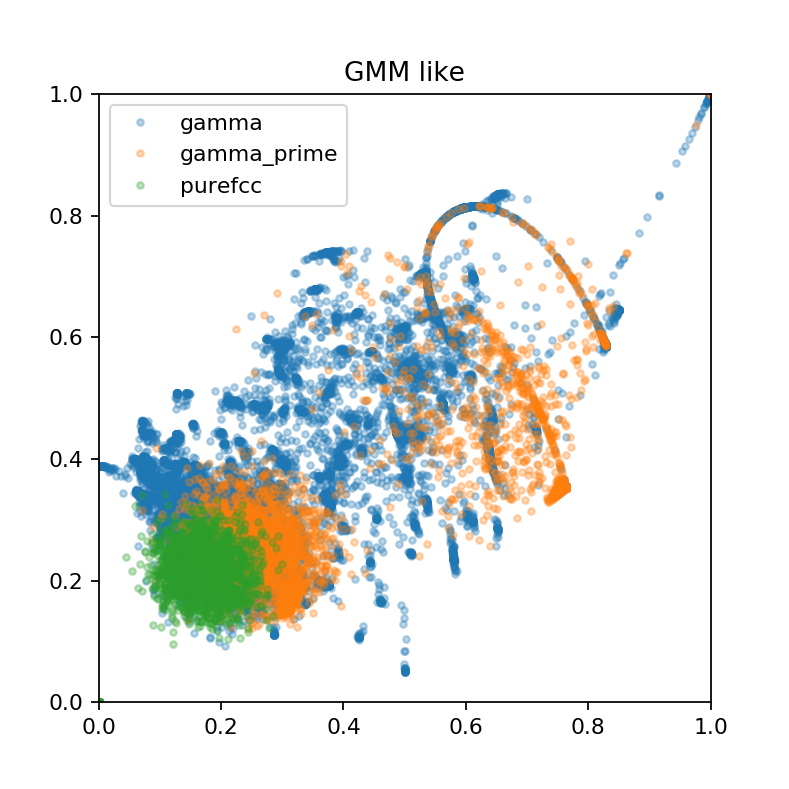

<IPython.core.display.Javascript object>


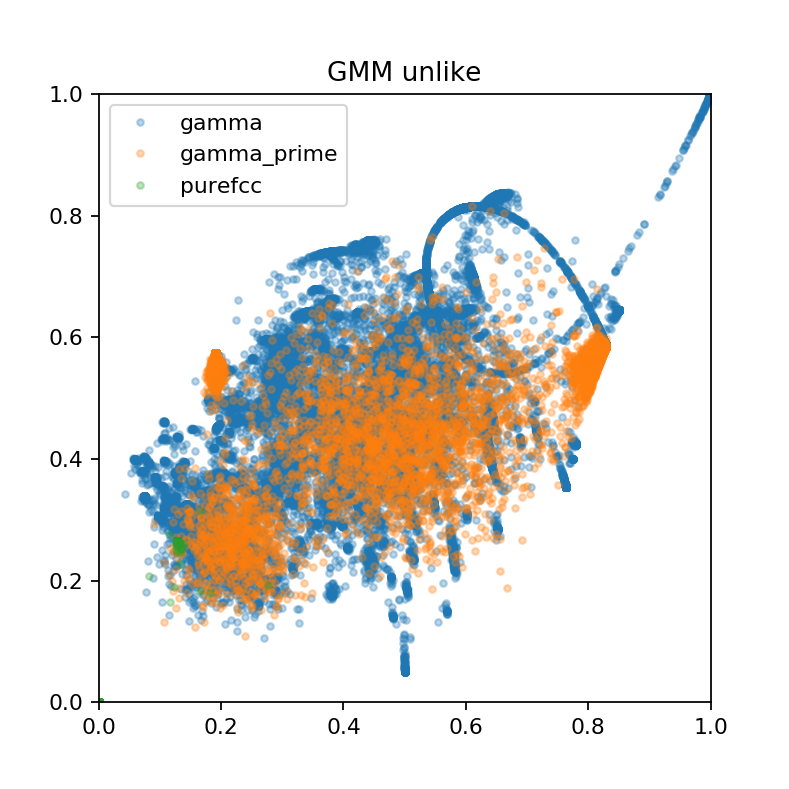

In [6]:
idx_class = {k:np.where(t_train==k)[0] for k in np.unique(t_train)}

xlim, ylim = (0,1), (0,1)
x, y = np.linspace(xlim[0],xlim[1],1000), np.linspace(ylim[0],ylim[1],1000)
xgrid, ygrid = np.meshgrid(x,y,indexing="ij")
X_plot = np.array([xgrid.ravel(), ygrid.ravel()]).T
s = xgrid.shape

# all
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for slabel in sorted(label_map):
    label = label_map[slabel]
    ix = idx_class[label]
    X = Phi_train[ix,:]    
    ax.plot(X[:,0], X[:,1],'.',label=slabel,alpha=.3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM like")
plt.legend(loc=0)
plt.show()

# like
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for slabel in sorted(label_map):
    label = label_map[slabel]
    ix = idx_class[label]
    X = Phi_train[ix,:]    
    ax.plot(X[:,2], X[:,3],'.',label=slabel,alpha=.3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM unlike")
plt.legend(loc=0)
plt.show()

## 6. Gaussian Mixture Based Classification

Here we use a modification of GMMs for the induction of a classifier. For an example with various classifiers, standardization and test/train splits see: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

### 6.1 Fit Gaussian Mixtures

Commonly GMM are used to approximate the complete distribution of all classes in feature space. The individual Gaussians are then related to the individual classes. Instead we approximate here the  feature space distribution for each class individually with a set of Gaussians. These approximations are then used to compare classes for a new position in feature space.

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<IPython.core.display.Javascript object>


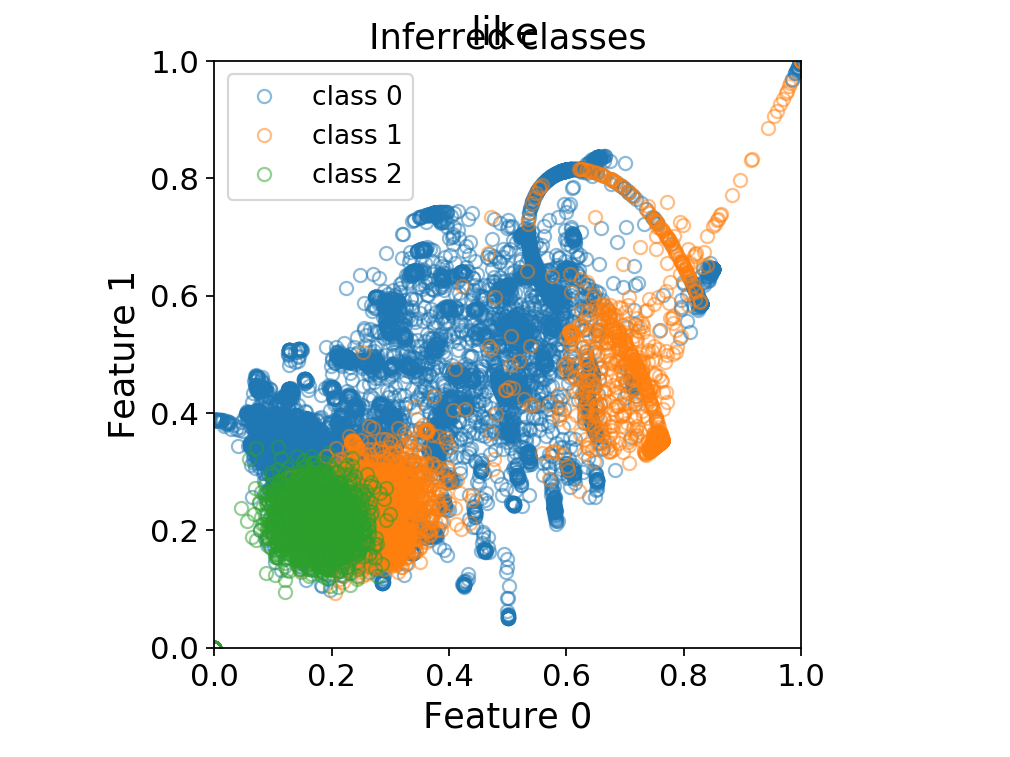

<IPython.core.display.Javascript object>


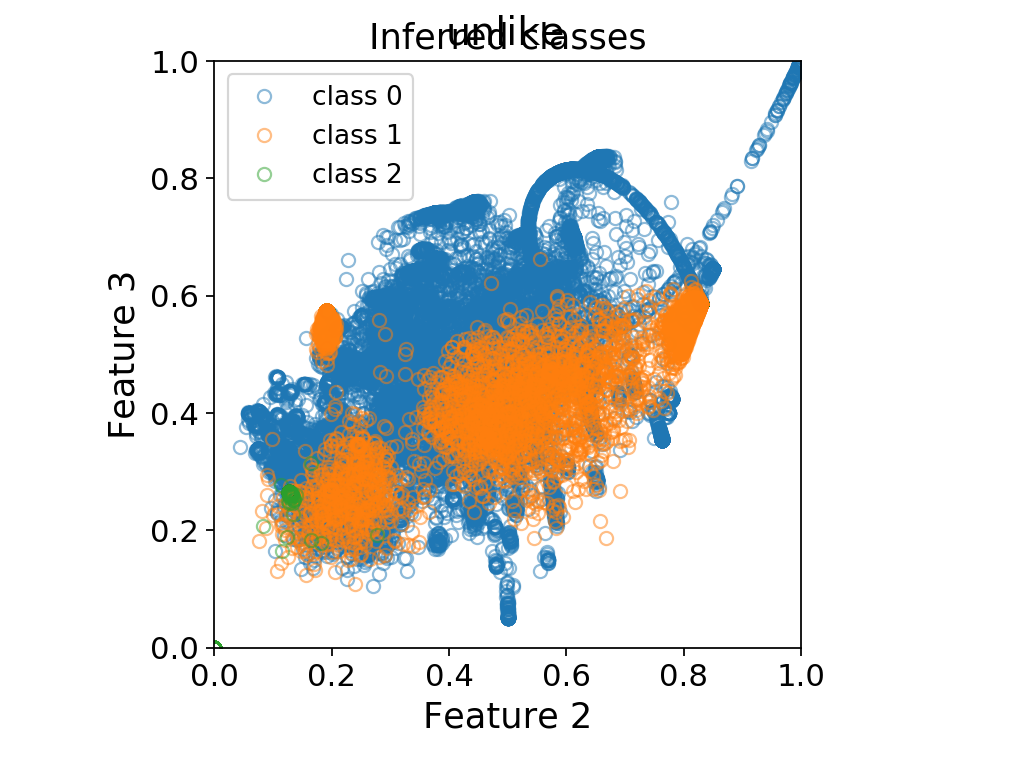

array([0, 0, 1, ..., 2, 2, 1], dtype=int64)

In [7]:
# choose mixture class
vgmm = BayesianGaussianMixture(n_components=25, weight_concentration_prior=1., 
                               covariance_type="full")
# initialize the classifier class with the chosen mixture class
gmc = atb.GaussianMixtureClassifier(gmm=vgmm)
# fitting the mixtures for all observations
gmc.fit(Phi_train, t_train, label_map=label_map)
gmc.predict(Phi_train, show=True, show_kwargs=dict(axes=[0,1], title="like"))
gmc.predict(Phi_train, show=True, show_kwargs=dict(axes=[2,3], title="unlike"))

### 6.2 Store the Classifier

In [8]:
print(gmc.fitted_gmms)
print(gmc.label_map)

{0: <function scipy_gmm_wrapper.<locals>.scipy_gmm at 0x0000019A15D7D268>, 1: <function scipy_gmm_wrapper.<locals>.scipy_gmm at 0x0000019A15D5BAE8>, 2: <function scipy_gmm_wrapper.<locals>.scipy_gmm at 0x0000019A15D5BC80>}
{'gamma_prime': 1, 'purefcc': 2, 'gamma': 0}


In [9]:
save_path = "BayesianGaussianMixtureClassifier_Ni-Al.pckl"
gmc.save(save_path)

### 6.3 Load the Classifier

In [10]:
load_path = "BayesianGaussianMixtureClassifier_Ni-Al.pckl"
gmc_load = atb.GaussianMixtureClassifier(load_path=load_path)

### 6.4 Classification Reports for Test and Train sets

In [11]:
print("\nTrain\n----")
print(sklearn.metrics.classification_report(t_train,gmc.predict(Phi_train), 
                                      target_names=sorted(label_map)))

print("\nTest\n----")
print(sklearn.metrics.classification_report(t_test,gmc.predict(Phi_test), 
                                      target_names=sorted(label_map)))


Train
----
             precision    recall  f1-score   support

      gamma       0.96      0.97      0.96     36189
gamma_prime       0.96      0.94      0.95     24941
    purefcc       1.00      1.00      1.00     15362

avg / total       0.97      0.97      0.97     76492


Test
----
             precision    recall  f1-score   support

      gamma       0.96      0.97      0.97     24394
gamma_prime       0.96      0.94      0.95     16531
    purefcc       1.00      1.00      1.00     10071

avg / total       0.97      0.97      0.97     50996



In [12]:
print("\nTrain\n----")
print(sklearn.metrics.classification_report(t_train,gmc_load.predict(Phi_train), 
                                      target_names=sorted(label_map)))

print("\nTest\n----")
print(sklearn.metrics.classification_report(t_test,gmc_load.predict(Phi_test), 
                                      target_names=sorted(label_map)))


Train
----
             precision    recall  f1-score   support

      gamma       0.96      0.97      0.96     36189
gamma_prime       0.96      0.94      0.95     24941
    purefcc       1.00      1.00      1.00     15362

avg / total       0.97      0.97      0.97     76492


Test
----
             precision    recall  f1-score   support

      gamma       0.96      0.97      0.97     24394
gamma_prime       0.96      0.94      0.95     16531
    purefcc       1.00      1.00      1.00     10071

avg / total       0.97      0.97      0.97     50996



### 6.5 F1 Score vs Degree of Perturbation

Next we rattle the crystals again with a variety of intensities and subsequently classify to get the F1 score as a function of the degree of perturbation of the crystal for the different phases.

In [13]:
Nrattle = 2
scales = [.001, .005, .01, .02, .03, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
rattle_rvs = [stats.norm(loc=0,scale=v) for v in scales]
CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

snames_map = {"Al":"purefcc", "Ni":"purefcc", "gamma_prime":"gamma_prime"}
for sname in atoms_dict:
    if "gamma" in sname and (not "prime" in sname):
        snames_map[sname] = "gamma"
print("snames_map ",snames_map)
print("label_map ",label_map)

F1_scores = {k:[] for k in label_map}
classification_stats = {k:{_k: [] for _k in label_map} for k in label_map}
for sname in sorted(atoms_dict):
    print("\nprocessing ",sname)
    for j in range(len(rattle_rvs)):
        print("    rv ",j+1,"/",len(rattle_rvs))
        _rpositions, _Natoms, _cells, _species = atb.rattle_crystal_multiple_rvs(Nrattle, [rattle_rvs[j]],\
                                    atoms_dict[sname])

        _rpositions_flat, _Natoms_flat, _cells_flat, _species_flat = atb.flattening_rattled_crystal_data(_rpositions,\
                                                            _Natoms, _cells, _species)

        for i in range(len(_rpositions_flat)): # looping rattle rv & crystal type
            
            _pos = _rpositions_flat[i]
            _cell = _cells_flat[i]
            _spec = _species_flat[i]

            _Phi, mapper = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                            num_neigh=num_neigh,
                                            features_class=featurers, params_features=featurer_params, 
                                            return_force=False, return_mapper=True)
            _Phi = _Phi[:,:-2]
            assert np.isfinite(_Phi).all(), "_Phi contains non-finite values."
            if i == 0:
                Phi_tmp = np.copy(_Phi)
            else:
                Phi_tmp = np.vstack((Phi_tmp,_Phi))

        y_tmp = gmc_load.predict(Phi_tmp)
        for _label, _val in label_map.items():
            classification_stats[snames_map[sname]][_label].append(np.sum(y_tmp == _val))
        
        #print("classification_stats ",classification_stats)
        if (y_tmp == label_map[snames_map[sname]]).sum() == 0:
            print("y_tmp ",y_tmp)
            print("label_map ",label_map)
            #raise
        y_tmp = y_tmp == label_map[snames_map[sname]]
        
        t_tmp = np.ones(Phi_tmp.shape[0],dtype=int) #np.array([label_map[snames_map[sname]] for v in range(Phi_tmp.shape[0])])
        
        F1_scores[snames_map[sname]].append(sklearn.metrics.f1_score(t_tmp,y_tmp))

snames_map  {'Al': 'purefcc', 'Ni': 'purefcc', 'gamma0.2Al#0': 'gamma', 'gamma0.2Al#1': 'gamma', 'gamma0.2Al#2': 'gamma', 'gamma_prime': 'gamma_prime', 'gamma0.2Al#4': 'gamma', 'gamma0.2Al#3': 'gamma'}
label_map  {'gamma_prime': 1, 'purefcc': 2, 'gamma': 0}

processing  Al
    rv  1 / 15
    rv  2 / 15
    rv  3 / 15
    rv  4 / 15
    rv  5 / 15
    rv  6 / 15
    rv  7 / 15
    rv  8 / 15
    rv  9 / 15
    rv  10 / 15
    rv  11 / 15
    rv  12 / 15
    rv  13 / 15
    rv  14 / 15
    rv  15 / 15

processing  Ni
    rv  1 / 15
    rv  2 / 15
    rv  3 / 15
    rv  4 / 15
    rv  5 / 15
    rv  6 / 15
    rv  7 / 15
    rv  8 / 15
    rv  9 / 15
    rv  10 / 15
    rv  11 / 15
    rv  12 / 15
    rv  13 / 15
    rv  14 / 15
    rv  15 / 15

processing  gamma0.2Al#0
    rv  1 / 15
    rv  2 / 15
    rv  3 / 15
    rv  4 / 15
    rv  5 / 15
    rv  6 / 15
    rv  7 / 15
    rv  8 / 15
    rv  9 / 15
    rv  10 / 15
    rv  11 / 15
    rv  12 / 15
    rv  13 / 15
    rv  14 / 15
    rv 

<IPython.core.display.Javascript object>


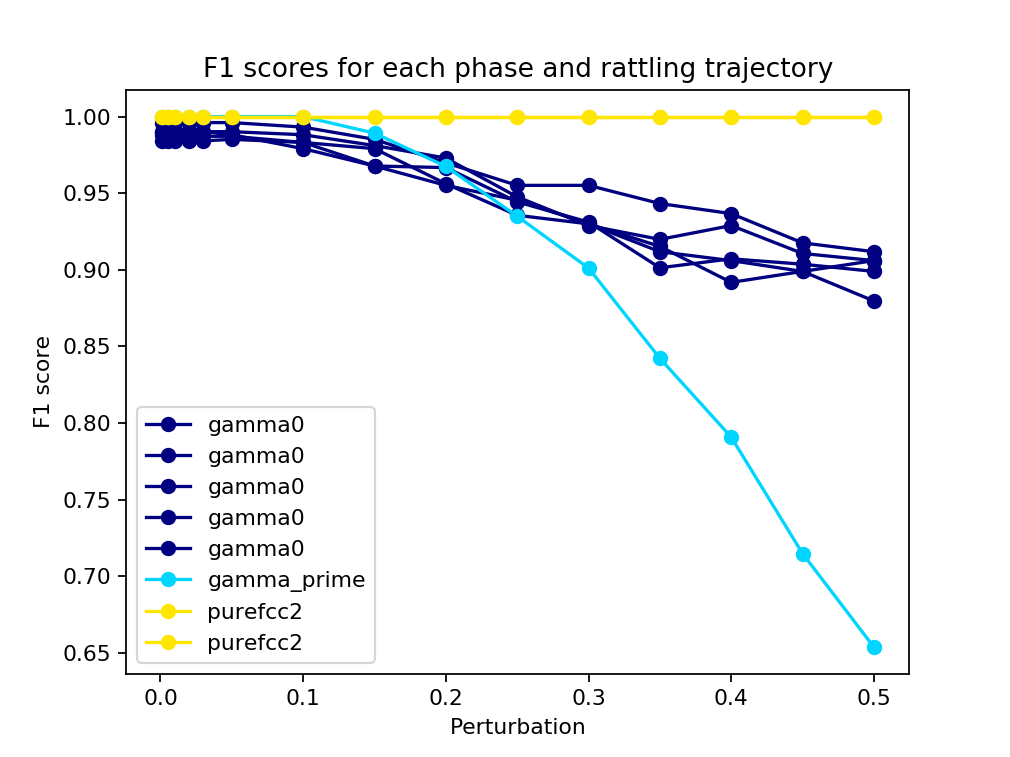

perturbations: 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5


In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.array(scales)
print("perturbations: {}".format(", ".join(["{:.2g}".format(v) for v in x])))
Nx = x.shape[0]
for i,sname in enumerate(sorted(F1_scores)):
    y = np.array(F1_scores[sname], dtype=float)
    Ny = y.shape[0]
    if Ny == Nx:
        ax.plot(x,y,'-o',label=sname, color=plt.cm.jet(i/float(len(F1_scores))))
    elif Ny > Nx and Ny%Nx==0:
        y = np.reshape(y,(int(Ny/float(Nx)),Nx))
        for j in range(int(Ny/float(Nx))):
            ax.plot(x,y[j],'-o',label=sname+str(i), color=plt.cm.jet(i/float(len(F1_scores))))
    else:
        raise ValueError
ax.set_xlabel("Perturbation")
ax.set_ylabel("F1 score")
ax.set_title("F1 scores for each phase and rattling trajectory")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


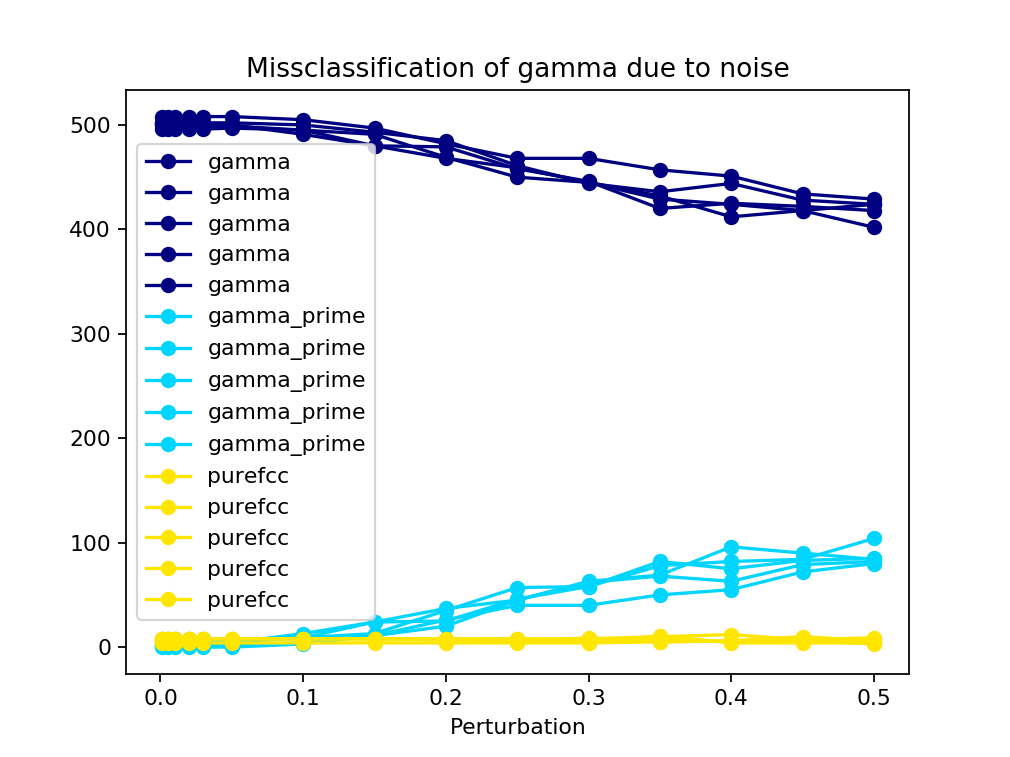

<IPython.core.display.Javascript object>


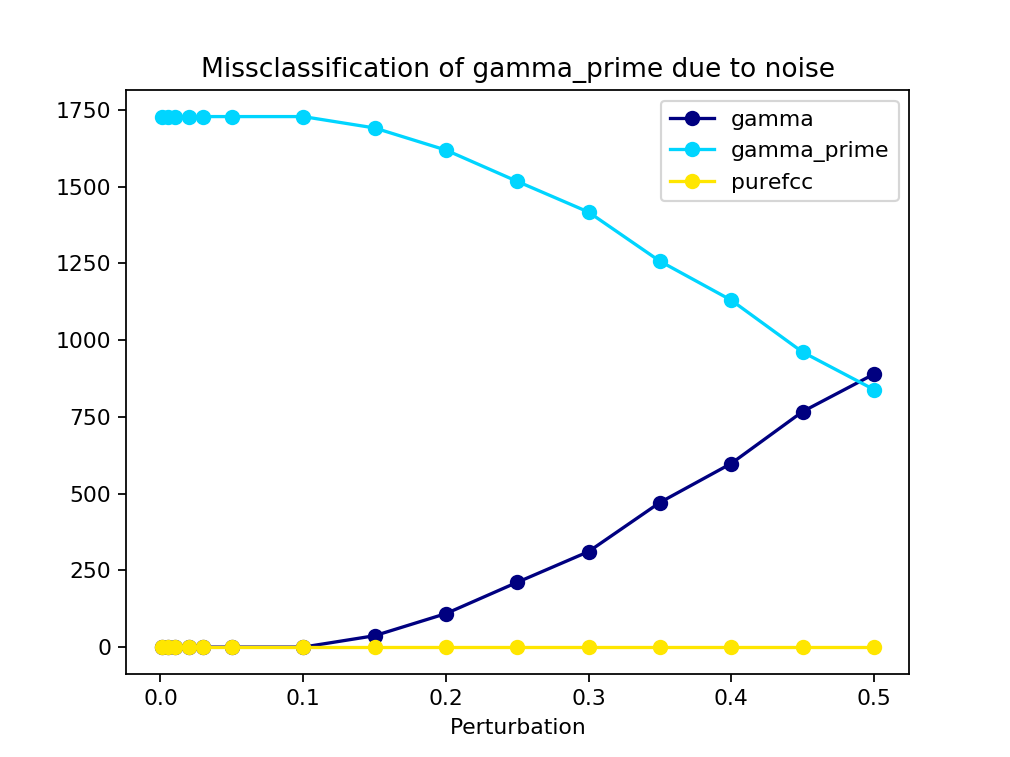

<IPython.core.display.Javascript object>


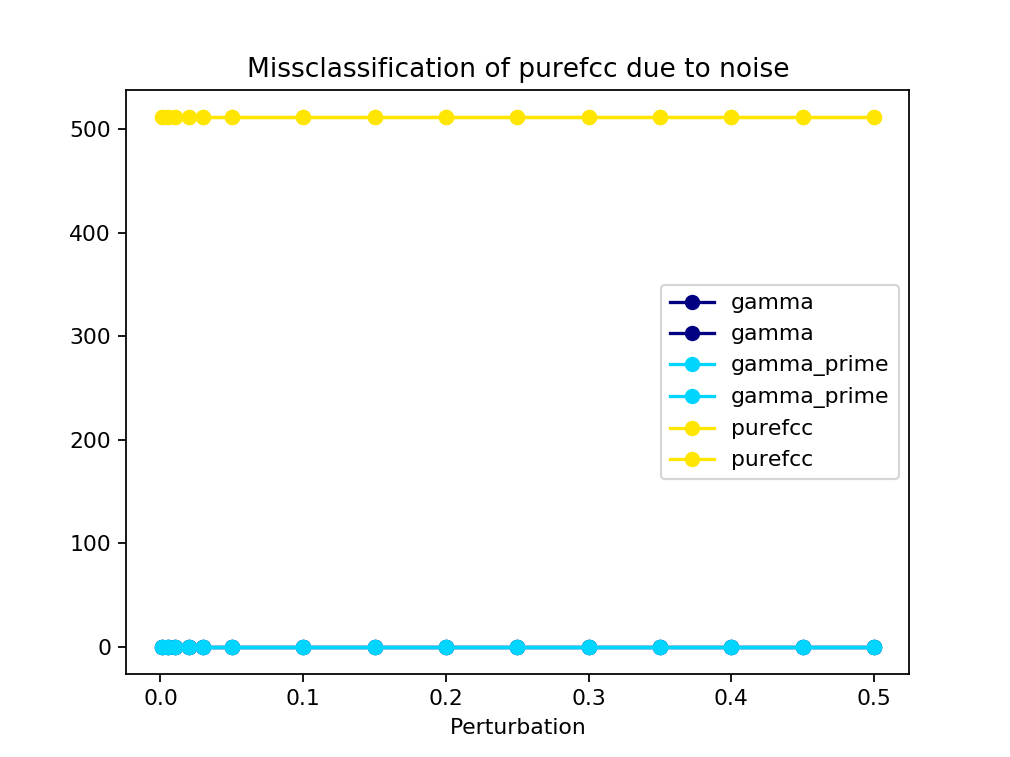

In [15]:
x = np.array(scales)
Nx = x.shape[0]

for label in sorted(classification_stats):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i,_label in enumerate(sorted(classification_stats[label])):
        
        y = np.array(classification_stats[label][_label])
        Ny = y.shape[0]
        
        if Ny == Nx:
            ax.plot(x,y,'-o',label=_label, color=plt.cm.jet(i/float(len(classification_stats[label]))))
        elif Ny > Nx and Ny%Nx==0:
            y = np.reshape(y,(int(Ny/float(Nx)),Nx))
            for j in range(int(Ny/float(Nx))):
                ax.plot(x,y[j],'-o',label=_label, color=plt.cm.jet(i/float(len(classification_stats[label]))))
        else:
            raise ValueError
    plt.legend(loc=0)
    ax.set_title("Missclassification of {} due to noise".format(label))
    ax.set_xlabel("Perturbation")
    plt.show()